# Attention is All You Need

In [1]:
import torch
from torch import nn
import torch.nn.functional as F

import numpy as np

<center><img src="images/transformer.PNG"/></center>

## Attention mecanism

$$\text{Attention} = \frac{QK^T}{\sqrt {d_k}}V$$

<center><img src="images/dot_att.PNG"/></center>


In [2]:
def attention(query, key, value, mask=None):
    
    d_model = query.size(-1)
    
    score = query @ key.transpose(-1, -2) / np.sqrt(d_model)
    
    if mask != None:
        score = score.masked_fill_(mask == 0, float('-inf'))
                
    normalized_score = F.softmax(score, dim=-1)
    
    output = normalized_score @ value
    
    return output, normalized_score



In [3]:
def get_masks(seq_ids, pad_idx=0):
    
    batch_size, max_len = seq_ids.size()
    
    mask = (seq_ids != 0).float().unsqueeze(-2).type_as(seq_ids) # batch_size, 1, max_len
    
    causal_mask = torch.tril(torch.ones(max_len, max_len)).type_as(seq_ids) # max_len, max_len
                    
    return mask, causal_mask

In [9]:
# Example

def create_synthetic_data(bs, slen):

    x = torch.zeros(bs, slen)

    for i in range(len(x)):

        xi_len = np.random.randint(5, slen)

        xi = torch.randint(0, 1000, size=(xi_len,))

        x[i, :xi_len] = xi
        
    score = torch.randn((bs, 8, slen, slen))

    return x, score

## score
x, score = create_synthetic_data(5, 17)

mask, causal = get_masks(x)

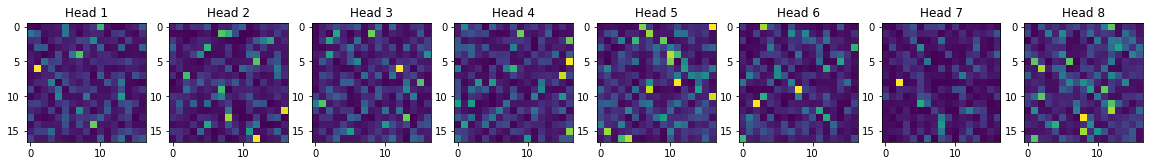

In [10]:
## masked score
score = score#.masked_fill_((causal).unsqueeze(-3)  == 0, float('-inf'))

## Normalize score with softmax
n_score = F.softmax(score, -1)

## Visualization 
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(20, 20))

columns = 8
rows = 1

for i in range(1, columns*rows +1):
    fig.add_subplot(rows, columns, i)
    plt.imshow(n_score[0][i - 1])
    plt.title(f'Head {i}')
    
plt.show()

### Multi-Head Attention

<center><img src="images/multi_head.png" style="center"/> <center>
    

In [24]:
class MHA(nn.Module):
    
    def __init__(self, d_model, n_head):
        super().__init__()
        
        assert d_model % n_head == 0
        
        self.d_model = d_model
        self.n_head = n_head
        
        
        self.W_q = nn.Linear(d_model, d_model, bias=False)
        self.W_k = nn.Linear(d_model, d_model, bias=False)
        self.W_v = nn.Linear(d_model, d_model, bias=False)
        
        self.W_o = nn.Linear(d_model, d_model)
        
    def forward(self, query, key, value, mask=None):
        # mask: [batch_size, *_]
        
        batch_size, *_ = query.size()
        
        if mask != None:
            # add dimension for head
            mask = mask.unsqueeze(-3)
        
        query = self.W_q(query)
        key = self.W_k(key)
        value = self.W_v(value)
        
        query = query.view(batch_size, -1, self.n_head, self.d_model//self.n_head).transpose(1, 2)
        key = key.view(batch_size, -1, self.n_head, self.d_model//self.n_head).transpose(1, 2)
        value = value.view(batch_size, -1, self.n_head, self.d_model//self.n_head).transpose(1, 2)
        
        output, att = attention(query, key, value, mask)
        
        output = output.transpose(1, 2).contiguous().view(batch_size, -1, self.d_model)
        
        return self.W_o(output)
    
    

## Positional encoding

$$PE_{(pos, 2i)} = sin(pos/10000^{2i/d_{model}})$$

$$PE_{(pos, 2i+1)} = cos(pos/10000^{2i/d_{model}})$$

In [25]:
class PositionEmbedding(nn.Module):
    
    def __init__(self, max_position, d_model):
        
        super().__init__()
        
        self.embedding = nn.Embedding(max_position, d_model)
                
        pe_pair = np.sin(
            np.array([[pos / np.power(10000, 2 * i / d_model) for i in range(0, d_model, 2)] for pos in range(max_position)])
        )
        
        pe_impair = np.cos(
            np.array([[pos / np.power(10000, 2 * i / d_model) for i in range(1, d_model, 2)] for pos in range(max_position)])
        )
                
        self.embedding.weight[:, 0::2] = torch.FloatTensor(pe_pair)
        self.embedding.weight[:, 1::2] = torch.FloatTensor(pe_impair)
        self.embedding.weight.detach_()
        self.embedding.weight.requires_grad = False
        
    def forward(self, x):
        
        batch_size, seq_len, d_model = x.size()
        
        positions = torch.arange(seq_len, device=x.device)
        
        pos_emb = self.embedding(positions).expand_as(x)
        
        return x + pos_emb
    
    

In [26]:
pos_emb = PositionEmbedding(150, 512)

In [29]:
weight = pos_emb.embedding.weight.data

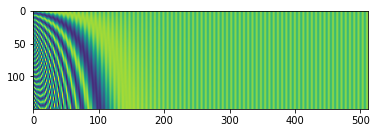

In [30]:
plt.imshow(weight)

## Layer Normalization

Layer normalization normalizes across the feature dimension (d_model).

In [31]:
class LayerNorm(nn.Module):
    def __init__(self, d_model, eps=1e-6):
        """Layer Normalization (see nn.LayerNorm(..))"""

        super().__init__()
        
        self.a = nn.Parameter(torch.ones(d_model))
        self.b = nn.Parameter(torch.zeros(d_model))
        self.eps = eps
        
    def forward(self, x):
        
        mean = x.mean(-1, keepdim=True)
        std = x.std(-1, keepdim=True)
        
        return self.a * (x - mean) / (std + self.eps) + self.b

## Feed Forward Layer

The positionwise feed-forward network transforms the representation at all the sequence positions using the same MLP.

In [33]:
class FeedForward(nn.Module):
    def __init__(self, d_model, d_ffn, activation=nn.ReLU()):
        super().__init__()
        
        self.layer = nn.Sequential(
            nn.Linear(d_model, d_ffn),
            activation,
            nn.Linear(d_ffn, d_model)
        )
        
    def forward(self, x):
        
        x = self.layer(x)
        
        return x

## Add & Norm

Residual connection followed by layer normalization

In [32]:
class AddNorm(nn.Module):
    
    def __init__(self, d_model):
        super().__init__()
        
        self.norm = LayerNorm(d_model)
        
    def forward(self, x, y):
        
        a = x + y
        
        return self.norm(a)

## Transformer Encoder block

<center><img src="images/encoder_block.PNG" align="center"/></center>

TransformerEncoderBlock class contains two sublayers: multi-head self-attention and positionwise feed-forward networks, where a residual connection
followed by layer normalization is employed around both sublayers.

In [34]:
class TransformerEncoderBlock(nn.Module):
    
    def __init__(self, d_model, n_head, d_ffn=1024):
        
        super().__init__()
        
        assert d_model % n_head == 0
        
        self.addnorm_1 = AddNorm(d_model)
        self.addnorm_2 = AddNorm(d_model)
        
        self.att = MHA(d_model, n_head)
        self.ffn = FeedForward(d_model, d_ffn)
        
    def forward(self, x, mask):
        
        x = self.addnorm_1(x, self.att(x, x, x, mask))
        
        x = self.addnorm_2(x, self.ffn(x))
        
        return x
    
    

## Transformer Encoder (Copy block N times)

We stack num_layers instances of the TransformerEncoderBlock

In [35]:
class TransformerEncoder(nn.Module):
    
    def __init__(self, d_model=512, n_head=8, num_layers=4, d_ffn=1024):
        
        super().__init__()
        
        assert d_model % n_head == 0
        
        self.layers = nn.ModuleList([TransformerEncoderBlock(d_model, n_head, d_ffn) for _ in range(num_layers)])
        
    def forward(self, x, mask=None):
        
        for encoder in self.layers:
            x = encoder(x, mask)
            
        return x

## Transformer Decoder block

<center><img src="images/decoder_block.PNG" align="center"/></center>

TransformerDecoderBlock class contains three sublayers: (masked) multi-head self-attention, encoder-decoder cross-attention and positionwise feed-forward networks A residual connection followed by layer normalization is employed around each sublayers.

In [34]:
class TransformerDecoderBlock(nn.Module):
    
    def __init__(self, d_model, n_head, d_ffn=1024):
        
        super().__init__()
        
        assert d_model % n_head == 0
        
        self.addnorm_1 = AddNorm(d_model)
        self.addnorm_2 = AddNorm(d_model)
        self.addnorm_3 = AddNorm(d_model)
        
        self.self_att = MHA(d_model, n_head)
        self.cross_att = MHA(d_model, n_head)
        self.ffn = FeedForward(d_model, d_ffn)
        
    def forward(self, y, memory, y_mask=None, memory_mask=None):
        
        y = self.addnorm_1(y, self.self_att(y, y, y, y_mask))
        
        y = self.addnorm_2(y, self.cross_att(y, memory, memory, memory_mask))
        
        y = self.addnorm_3(y, self.ffn(y))
        
        return y
    
    

## Transformer Decoder (Copy block N times)

We stack num_layers instances of the TransformerDecoderBlock

In [35]:
class TransformerDecoder(nn.Module):
    
    def __init__(self, d_model=512, n_head=8, num_layers=1, d_ffn=1024):
        
        super().__init__()
        
        assert d_model % n_head == 0
        
        self.layers = nn.ModuleList([TransformerDecoderBlock(d_model, n_head, d_ffn) for _ in range(num_layers)])
        
    def forward(self, y, memory, y_mask=None, memory_mask=None):
        
        for decoder in self.layers:
            y = decoder(y, memory, y_mask, memory_mask)
            
        return y

## Transformer (Encoder + Decoder)

In [36]:
class Transformer(nn.Module):
    def __init__(self, d_model=512, n_head=8, num_layers=1, d_ffn=1024):
        super().__init__()
        
        self.encoder = TransformerEncoder(d_model, n_head, num_layers, d_ffn)
        self.decoder = TransformerDecoder(d_model, n_head, num_layers, d_ffn)
        
        
    def forward(self, x, y, x_mask=None, y_mask=None):
        
        memory = self.encoder(x, x_mask)
        prediction = self.decoder(y, memory, y_mask, x_mask)
        
        return prediction